In [1]:
import os
import random
from collections import deque
from operator import itemgetter

import gym_donkeycar
import gymnasium as gym
import imageio
import ipywidgets as widgets
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from IPython.display import display
from ipywidgets import HBox, VBox
from matplotlib import pyplot as plt
from PIL import Image
from ruamel.yaml import YAML
from tensorboard import notebook
from tensorboard.backend.event_processing.event_accumulator import \
    EventAccumulator
from torch import distributions as dist
from torch.distributions import Categorical, Normal
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["IMAGEIO_IGNORE_WARNINGS"] = "True"

import gym.spaces as gym_spaces
import gymnasium as gym  # overwrite OpenAI gym
import stable_baselines3 as sb3
from gym_donkeycar.envs.donkey_env import DonkeyEnv
from gymnasium import spaces
from gymnasium.spaces import Box
from src.actor_critic import ContinuousActorCritic
from src.blocks import CategoricalStraightThrough, ConvBlock
from src.categorical_vae import CategoricalVAE
from src.imagination_env import ImaginationEnv
from src.mlp import MLP
from src.preprocessing import grayscale_transform as transform
from src.replay_buffer import ReplayBuffer
from src.rssm import RSSM
from src.utils import load_config, save_image_and_reconstruction, to_np
from stable_baselines3 import A2C, PPO, SAC
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import DummyVecEnv

torch.cuda.empty_cache()
%matplotlib inline

## Load Hyperparameters from YAML config

In [2]:
config = load_config()

for key in config:
    locals()[key] = config[key]

print(config)

{'device': device(type='cuda', index=0), 'A': 3, 'Z': 1024, 'debug': False, 'log_dir': 'logs/', 'seed': 0, 'toy_env': True, 'exe_path': '/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64', 'env_id': 'donkey-minimonaco-track-v0', 'port': 9091, 'size': [128, 128], 'grayscale': False, 'n_envs': 1, 'n_episodes': 5000, 'max_episode_steps': 500, 'max_imagination_episode_steps': 30, 'imagination_timesteps_per_model_update': 500, 'max_grad_norm': 1, 'batch_size': 1, 'H': 512, 'uniform_ratio': 0.01, 'buffer_size': 10000, 'activation': 'silu', 'num_categoricals': 32, 'num_classes': 32, 'channels': [32, 64, 128, 256, 256, 256], 'kernel_size': 3, 'stride': 2, 'padding': 1, 'conv_bias': False, 'entropyloss_coeff': 0.0, 'decoder_final_activation': 'sigmoid', 'pred_loss_coeff': 1.0, 'dyn_loss_coeff': 0.5, 'rep_loss_coeff': 0.1, 'free_nats': 1.0, 'num_rnn_layers': 1, 'mlp_n_layers': 3, 'mlp_hidden_dims': 256, 'store_on_cpu': True, 'gamma': 0.999, 'lam': 0.95, 'entropy_coeff': 0.

## Init the RSSM (including all networks)

In [3]:
rssm = RSSM().to(device)

rssm_optim = optim.Adam(
    rssm.parameters(), 
    lr=1e-4,
    weight_decay=1e-6, # l2 regularizer
)

Initializing encoder:
- adding ConvBlock((3, 32))                   ==> output shape: (32, 64, 64) ==> prod: 131072
- adding ConvBlock((32, 64))                   ==> output shape: (64, 32, 32) ==> prod: 65536
- adding ConvBlock((64, 128))                   ==> output shape: (128, 16, 16) ==> prod: 32768
- adding ConvBlock((128, 256))                   ==> output shape: (256, 8, 8) ==> prod: 16384
- adding ConvBlock((256, 256))                   ==> output shape: (256, 4, 4) ==> prod: 4096
- adding ConvBlock((256, 256))                   ==> output shape: (256, 2, 2) ==> prod: 1024
- adding Flatten()
- adding Reshape: (*,1024) => (*,32,32)

Initializing decoder:
- adding Reshape: (*,1024) => (*,256,2,2)
- adding transpose ConvBlock(256, 256)                   ==> output shape: (256, 4, 4) ==> prod: 4096
- adding transpose ConvBlock(256, 256)                   ==> output shape: (256, 8, 8) ==> prod: 16384
- adding transpose ConvBlock(256, 256)                   ==> output shape: (256, 1

## Create the imagination environment for training the agent

In [4]:
replay_buffer = ReplayBuffer()

In [5]:
imagination_env = ImaginationEnv(
    rssm,
    replay_buffer,
    render_mode=None
)

## Init the agent

In [6]:
agent = A2C(
    "MlpPolicy",
    imagination_env,
    verbose,
    tensorboard_log=log_dir
)

## Training loop


In [7]:
""" training loop """

rssm.train()

# Create the environment
if toy_env:
    assert A==3
    env = gym.make("CarRacing-v2", max_episode_steps=max_episode_steps, render_mode="rgb_array")
else:
    assert A==2
    sim_config = {
        "exe_path" : config["exe_path"],
        "port" : config["port"]
    }
    env = gym.make(
        "GymV21Environment-v0", 
        env_id=env_id,
        max_episode_steps=max_episode_steps,
        make_kwargs={
            "conf": sim_config
        })

# Logging
writer = SummaryWriter(log_dir)
notebook.start(f"--logdir={log_dir}")

episode_losses = { # for loss plots
    "episode_loss": [],
    "episode_image_loss": [],
    "episode_reward_loss": [],
    "episode_continue_loss": [],
    "episode_dyn_loss": [],
    "episode_rep_loss": [],
}

try:
    for episode in tqdm(range(n_episodes)):

        # Get the initial state
        obs, info = env.reset()

        # Reset the RNN's hidden state
        h = torch.zeros(rssm.num_rnn_layers, 1, H, device=device) # seq_len, B, H

        # Add a new loss for the current episode and initialize it to 0
        episode_length = 0
        for key in episode_losses:
            episode_losses[key].append(torch.tensor(0, device=device, dtype=torch.float32))

        # Play one episode
        done = False
        while not done:

            # preprocess the observation and add it to the replay buffer
            x = transform(obs).view(-1, 1 if grayscale else 3, *size) # (B, 3, 128, 128)
            replay_buffer.push(x)

            """ WORLD MODEL LEARNING """

            # predict z and generate the true stochastic latent variable z with the encoder
            z_prior = rssm.dynamics_mlp(h).view(-1, num_categoricals, num_classes) # (1,32,32) for the softmax
            z_prior = F.softmax(z_prior, -1).flatten(start_dim=1, end_dim=2) # (1, 1024)
            z = rssm.vae.encode(x).flatten(start_dim=1, end_dim=2)
            
            # apply the RL agent in eval mode to get an action
            state = to_np(torch.cat((h.flatten().detach(), z.flatten().detach()), dim=0))
            action, _ = agent.predict(state, deterministic=True)

            # predict one step using the RSSM
            h, reward_pred, continue_prob, continue_pred, x_pred = rssm.step(action, h, z)

            # take an environment step with the action
            obs, reward, terminated, truncated, info = env.step(action.squeeze())
            done = terminated or truncated

            # calculate the loss
            continue_target = torch.tensor(1 - done, device=device, dtype=torch.float32)
            reward = torch.tensor(reward, device=device, dtype=torch.float32)
            losses = rssm.get_losses(x, x_pred, reward, reward_pred, 
                                     continue_target, continue_prob, z_prior, z)

            # Add the loss for the current step to the episode loss
            episode_length += 1
            for key in losses:
                episode_losses["episode_" + key][-1] += losses[key]

        # Calculate the mean loss of the episode
        for key in episode_losses:
            episode_losses[key][-1] /= episode_length

        # update the world model at the end of an episode using the mean loss of the episode
        rssm_optim.zero_grad()
        episode_losses["episode_loss"][-1].backward()
        nn.utils.clip_grad_norm_(rssm.vae.parameters(), max_norm=max_grad_norm, norm_type=2)  
        rssm_optim.step()

        # Detach the losses to save memory and log them in TensorBoard
        for key in episode_losses:
            episode_losses[key][-1] = episode_losses[key][-1].detach().item()
            writer.add_scalar(key, episode_losses[key][-1], global_step=episode)
        
        # save original image and reconstruction
        if episode % 10 == 0:
            save_image_and_reconstruction(x, x_pred, episode)
        
        """ RL AGENT LEARNING (IN THE WORLD MODEL) """
        agent.learn(
            total_timesteps=imagination_timesteps_per_model_update,
            progress_bar=imagination_progress_bar,
            reset_num_timesteps=False
        )

    env.close()

except KeyboardInterrupt:
    """ Clean handling for interrupts to stop training early """
    print("Stopping training.")
    # Delete the last loss if the training was stopped early
    # so that the list only consists of floats
    for key in episode_losses:
        if isinstance(episode_losses[key][-1], torch.Tensor):
            episode_losses[key] = episode_losses[key][:-1]

    # Close the TensorBoard writer and the gym environment
    writer.close()
    env.close()

  0%|                                                                                       | 1/5000 [00:09<12:36:52,  9.08s/it]

Stopping training.


## Plot the results

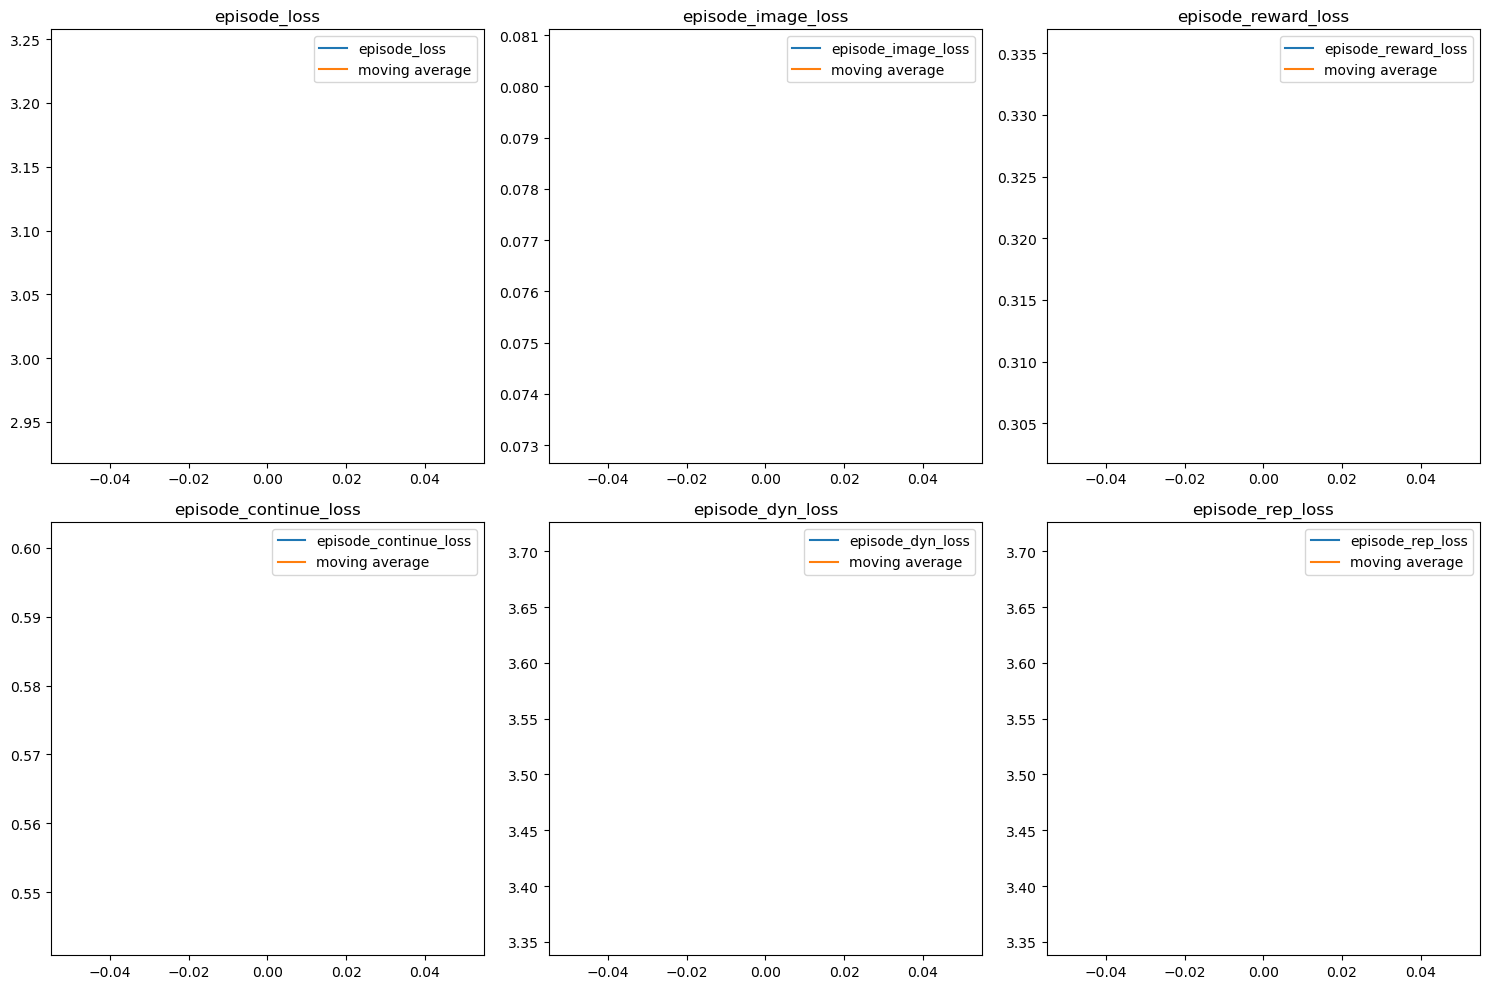

In [8]:
rolling_length = max(1, int(len(episode_losses["episode_loss"])/20))

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3*5, 2*5))

# Iterate over the keys and plot the losses
for i, key in enumerate(episode_losses.keys()):
    row = i // 3
    col = i % 3

    axs[row, col].set_title(key)
    losses = episode_losses[key]
    losses_moving_average = (
        np.convolve(
            np.array(losses).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    axs[row, col].plot(range(len(losses)), losses, label=key)
    axs[row, col].plot(range(len(losses_moving_average)), losses_moving_average, label="moving average")
    axs[row, col].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Showcase the trained agent playing in latent imagination

In [15]:
showcase_agent = True

if showcase_agent:
    
    imagination_env.render_mode = "gif"
    obs, info = imagination_env.reset()
    
    for i in range(max_episode_steps):
        
        # apply the RL agent in eval mode to get an action
        state = to_np(torch.cat((h.flatten().detach(), z.flatten().detach()), dim=0))
        action, _ = agent.predict(state, deterministic=True)
        
        obs, reward, terminated, truncated, info = imagination_env.step(action)
        imagination_env.render()
        
    imagination_env.close()
    imagination_env.render_mode = None

## Test area

In [13]:
# GPU memory consumption:
# 10 steps -> 6504MiB
# 50 steps -> 19990MiB

In [14]:
# !tensorboard --logdir=log_dir